# Introduction

My friend [Johannes Giorgis] and I are developing a series of [Data Science Challenges] to help others
become better data scientists by presenting a series of challenges.  Why did we do this?


> Because that's what heroes do!
>
> --Johannes Giorgis

I now present my response to the first challenge, Exploring the Meetup API in the city of my choice.

**San Francisco, CA**, I choose you!



# Challenge 01: Explore the Meetup API
Use the [Meetup API] to explore meetups in your city of choice.


**Guide Questions**:

Below are some guide line questions to get you started:

- What is the largest meetup in your location of choice (city, cities, country...etc)?
- How many meetups of a certain category (e.g. Tech, Art...etc) are in your city?
- Basic statistics of meetups
	- What is the average size of meetups?
	- How frequently do meetups host events?
    
## Okay, but what I really want to know is

What is the biggest Tech Group in San Francisco that meets regularly and has a growing and enthusiastic membership?


## Prerequisites:
Add a [Meetup API Key] to your environment.

[//]: # (References)

[Meetup API]: https://www.meetup.com/meetup_api/
[Meetup API Key]: https://secure.meetup.com/meetup_api/key/
[Johannes Giorgis]: http://johannesgiorgis.com/
[Data Science Challenges]: https://medium.com/red-panda-ai/introducing-data-science-challenges-4ae4a103d67b

In [1]:
import datetime
import json
import math
import meetup.api
import os
import pprint
import requests

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb

from tqdm import tnrange, tqdm_notebook

%matplotlib inline

## Double check your environment

Nothing works without **MEETUP_API_KEY**.

In [2]:
assert 'MEETUP_API_KEY' in os.environ, (
    "You need a MEETUP_API_KEY in your environment please look at the "
    "README for instructions.")
client = meetup.api.Client()

## Categories

There are multiple categories of groups in Meetup, let's use Python's meetup.api to [GetCategories](https://meetup-api.readthedocs.io/en/latest/meetup_api.html#meetup.api.meetup.api.Client.GetCategories).

In [3]:
%%capture --no-display
categories = client.GetCategories()

### What are the attributes of the response object? 

First, 
let's create ahelper function to help us parse out the two most useful
different pieces:

1.  **meta**: an object containing meta-data about the response object itself
2.  **results**: A page of actual data from the entire result of our API call

In [4]:
def parse_response(response):
    """Returns two dataframes, meta and results:
        meta: a vertically aligned dataframe, where each row is an element 
            of the response.meta dictionary
        results: a horizontally aligned dataframe, where each column is
        an element of the response.results dictionary"""
    meta = pd.DataFrame.from_dict(response.meta, orient='index')
    results = pd.DataFrame.from_dict(response.results)
    return meta, results


### Exploring the response object

We received a response object when we called ```client.GetCategories()```.

By looking at the categories **meta** dataframe, we can see that there are 33 different categories.

In [5]:
cats_meta_df, cats_df = parse_response(categories)
cats_meta_df

,0
next,
method,Categories
total_count,33
link,https://api.meetup.com/2/categories
count,33
description,Returns a list of Meetup group categories
lon,None
title,Categories
url,https://api.meetup.com/2/categories?offset=0&f...
id,


We can see from the meta that there are 33 categories available to us.
I wonder what they are.  

### How the Meetup API works

Notice that the value of **next** (above) is an empty string.  Meetup API v2 response payloads come in **pages**, one at a time, but provide the URI of the **next** API call in the sequence.  We can use this to programmatically get each next **page** in **response.meta\["next"\]**. until the complete result is returned.

As we can see, the **response.meta\["next"\]** for this page is an empty string, so all of the categories
fit into our first API call.

#### Secondly, let's review the categories results dataframe

In [6]:
cats_df

,id,name,shortname,sort_name
0,1,Arts & Culture,Arts,Arts & Culture
1,18,Book Clubs,Book Clubs,Book Clubs
2,2,Career & Business,Business,Career & Business
3,3,Cars & Motorcycles,Auto,Cars & Motorcycles
4,4,Community & Environment,Community,Community & Environment
5,5,Dancing,Dancing,Dancing
6,6,Education & Learning,Education,Education & Learning
7,8,Fashion & Beauty,Fashion,Fashion & Beauty
8,9,Fitness,Fitness,Fitness
9,10,Food & Drink,Food & Drink,Food & Drink


### So, if we want to work with a particular category
In this case, I want **Tech**. Let's query the dataframe for categories named **Tech**.

In [7]:
tech_df = cats_df.loc[cats_df['name'] == 'Tech']
tech_df

,id,name,shortname,sort_name
31,34,Tech,Tech,Tech


### Let's store the category ID number for later use

In [8]:
tech_category_id = tech_df['id'].values[0]
tech_category_id

34

## Explore Cities
### Now let's look at cities in the United States named San Francisco

In [9]:
%%capture --no-display
cities_resp = client.GetCities(country='us', query='San Francisco')

Here we used the [GetCities] method of the [Python Meetup API client]

I used a query for cities in **United States** called **San Francisco**.

[//]: # (References)

[GetCities]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#meetup.api.meetup.api.Client.GetCities
[Python Meetup API client]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#api-client-details

Now let's take a look at the **meta** for our results.

In [10]:
cities_meta_df, cities_df = parse_response(cities_resp)
cities_meta_df

,0
next,
method,Cities
total_count,4
link,https://api.meetup.com/2/cities
count,4
description,Returns Meetup cities. This method supports se...
lon,None
title,Cities
url,https://api.meetup.com/2/cities?country=us&off...
id,


### Hmm, a count of 4 cities is suspicious...

I only know of the one San Francisco, why are there 4 cities?

In [11]:
cities_df

,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,San Francisco,us,94101,37.779999,USA,-122.419998,60351,"San Francisco, California, USA",0,CA,94101
1,Bosque,us,87006,34.560001,USA,-106.779999,5,"San Francisco, New Mexico, USA",1,NM,87006
2,San Luis,us,81152,37.080002,USA,-105.620003,4,"San Francisco, Colorado, USA",2,CO,81152
3,Reserve,us,87830,33.650002,USA,-108.769997,1,"San Francisco Plaza, New Mexico, USA",3,NM,87830


Oh, there are lot's of San Franciscos!

### Let's filter the dataframe with a query to give us only cities in California, US

In [12]:
single_city_df = cities_df.loc[
    (cities_df['state'] == 'CA')]

single_city_df

,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,San Francisco,us,94101,37.779999,USA,-122.419998,60351,"San Francisco, California, USA",0,CA,94101


One San Francisco, perfect!  

### Let's store the latitude and longitude for later use as well

In [13]:
latitude = single_city_df['lat'][0]
longitude = single_city_df['lon'][0]
latitude, longitude

(37.779998779296875, -122.41999816894531)

## Now let's look at groups in San Francisco, CA

### Since we are going to grab lots of groups, lets make a function to help us call the API

Note, this function will use the tech_category_id, latitude, and longitude values that we 
found eariler.

In [14]:
def get_a_group(page_number, category_id=tech_category_id, lat=latitude,
               lon=longitude):
    group = None
    retry_counter, retry_max = 0, 3
    print(f"Getting page {page_number}")
    while retry_counter < retry_max:
        try:
            group = client.GetGroups(
            category_id=category_id, lat=lat, lon=lon, offset=page_number)
            return group
        except:
            print(f"Fetch failure {retry_counter + 1}")
            retry_counter += 1

    raise Exception(f"Unable to fetch page after {retry_counter} attempts")

### Now, After grabbing the first group

Let's review the **meta** to help us see what we are getting into

In [15]:
%%capture --no-display
group_resp = get_a_group(0)
group_meta, _ = parse_response(group_resp)
group_meta

,0
next,https://api.meetup.com/2/groups?offset=1&forma...
method,Groups
total_count,2195
link,https://api.meetup.com/2/groups
count,200
description,None
lon,-122.42
title,Meetup Groups v2
url,https://api.meetup.com/2/groups?offset=0&forma...
id,


### Wait! There's a meta[\"next\"].

Remember earlier when I spoke about **response.meta\["next"\]**?  

It seems as though our result will span mulitple API calls, each returning 200 new groups in 
a **page**.

Let's make a new helper that will grab each **page** in a series of API calls until we obtain the entire data set:

We will use the pandas.DataFrame.[concat] function to collate all pages into a single useful dataframe

[//]: # (References)

[concat]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

In [16]:
def get_all_groups_as_a_df():
    """Returns a single dataframe composed from data from multiple
    successive calls to get_a_group.
    
    We will loop through get_a_group pages while our page.meta['next'] is 
    not the empty string.
    """
    page_df_list = []
    next_page = None
    page_number = 0
    while next_page != '':  
        page = get_a_group(page_number)
        next_page = page.meta["next"]
        _, frame = parse_response(page)
        page_number += 1
        page_df_list.append(frame)
        
    return pd.concat(page_df_list, ignore_index=True)



In [17]:
# Collect all groups into a single dataframe
all_groups_df = get_all_groups_as_a_df()

# Show the first row in the dataframe
all_groups_df.head(1)

Getting page 0
28/30 (6 seconds remaining)
Getting page 1
27/30 (6 seconds remaining)
Getting page 2
26/30 (5 seconds remaining)
Getting page 3
25/30 (4 seconds remaining)
Getting page 4
24/30 (2 seconds remaining)
Getting page 5
23/30 (1 seconds remaining)
Getting page 6
22/30 (0 seconds remaining)
Getting page 7
29/30 (10 seconds remaining)
Getting page 8
28/30 (9 seconds remaining)
Getting page 9
27/30 (8 seconds remaining)
Getting page 10
26/30 (7 seconds remaining)


,category,city,country,created,description,group_photo,id,join_mode,lat,link,...,name,organizer,rating,state,timezone,topics,urlname,utc_offset,visibility,who
0,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",San Francisco,US,1034097740000,<p>The SF PHP Community Meetup is an open foru...,{'highres_link': 'https://secure.meetupstatic....,120903,open,37.77,https://www.meetup.com/sf-php/,...,SF PHP Community,"{'member_id': 126468982, 'name': 'Andre Marigo...",4.38,CA,US/Pacific,"[{'urlkey': 'php', 'name': 'PHP', 'id': 455}, ...",sf-php,-28800000,public,PHP Developers


### That's too many columns
I really only care about a small list of columns, let's exclude the unneeded columns.

In [18]:
column_list = ['id', 'name', 'members', 'rating', 'join_mode', 'urlname']
all_groups_df = all_groups_df[column_list]
all_groups_df.head(1)

,id,name,members,rating,join_mode,urlname
0,120903,SF PHP Community,2700,4.38,open,sf-php


### Let's double check the size of our new dataframe

In [19]:
all_groups_df.shape

(2195, 6)

That looks just about right:
* 2195 rows
* 6 columns

---
## Explore Members per Group

Each group has a different sized membership, let's explore this first!


### Let's start with with a histogram

This visualization should give us a basic idea of how big our groups are.

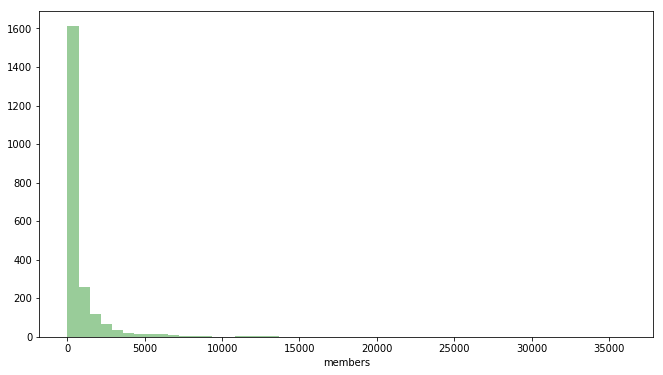

In [20]:
# Using seaborn's distplot function
plt.rcParams['figure.figsize'] = [11, 6]
sb.distplot(all_groups_df['members'], kde=False, color="g");

### It appears that most groups are relatively small

Let's take a closer look at some basic stats for our data in a tabular 
format for some hard numbers:

In [21]:
pd.options.display.float_format = '{:20,.2f}'.format
all_groups_df[["members", "rating"]].describe()

,members,rating
count,"2,195.00","2,195.00"
mean,812.37,2.74
std,"1,741.64",2.34
min,1.00,0.00
25%,87.00,0.00
50%,256.00,4.46
75%,780.50,4.84
max,"36,057.00",5.00


As a table I can see some numbers:

1.  It looks like the average group size is about 812 persons.
2.  Half of the group sits at or under 256 members.
3.  The smallest group has a single person.
4.  **the largest group has 36,000+ members!**

What an outlier!  But are there other **mega-groups** like this?

### Maybe a box and whisker plot can visualize these stats for us

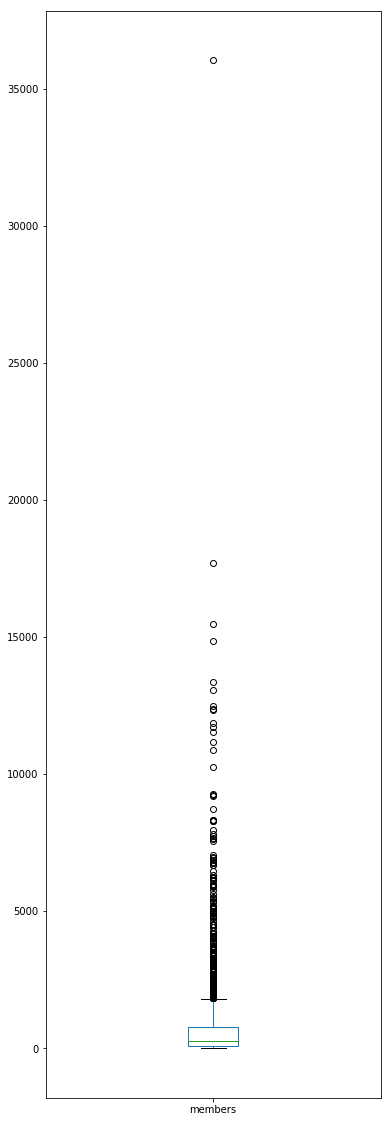

In [22]:
plt.rcParams['figure.figsize'] = [6, 20]
all_groups_df['members'].plot.box();

Wow, there are quite a few **mega-groups**, as indicated by the circles above our top whisker!

---

Why are the groups so big?

In fact...

### What are the 10 biggest tech groups in the area?

In [23]:
biggest_ten_df = all_groups_df.sort_values('members', ascending=False).head(10)
biggest_ten_df

,id,name,members,rating,join_mode,urlname
19,844726,Silicon Valley Entrepreneurs & Startups,36057,4.58,open,sventrepreneurs
107,1619955,SFHTML5,17716,4.67,open,sfhtml5
106,1615633,Designers + Geeks,15466,4.46,open,designersgeeks
426,9226282,SF Data Science,14873,4.49,open,SF-Data-Science
28,1060260,The SF JavaScript Meetup,13358,4.54,open,jsmeetup
250,3483762,Tech in Motion Events: San Francisco,13090,4.48,approval,TechinMotionSF
540,13402242,Docker Online Meetup,12475,4.37,open,Docker-Online-Meetup
191,2065031,SF Data Mining,12378,4.64,open,Data-Mining
201,2252591,Women Who Code SF,12335,4.78,open,Women-Who-Code-SF
706,18354966,SF Big Analytics,11880,4.53,open,SF-Big-Analytics


## Get Group Events

### We need to do some data shaping before the next api call

Mostly we need to:
1.  pass in a string with group ids from our 10 biggest groups
2.  convert our human-readable date ranges to milliseconds since Jan 1, 1970
3.  Call the GetEvents API filtering for past events using our group IDs and our date range

#### First, let's make that string of group ids


In [24]:
id_list = biggest_ten_df['id'].tolist()
id_list
ids = ','.join(str(x) for x in id_list)
ids

'844726,1619955,1615633,9226282,1060260,3483762,13402242,2065031,2252591,18354966'

#### Now, let's get the epoch milliseconds for a date range between now and 9 months ago

In [25]:
def to_millis(dt):
    return int(pd.to_datetime(dt).value / 1000000)

right_now = to_millis(datetime.datetime.now())
nine_months_ago = int(right_now - 180 * 24 * 60 * 60 * 1000)
print(f"Now: {right_now}, nine months ago: {nine_months_ago}")

Now: 1550864989674, nine months ago: 1535312989674


#### Finally, let's look at those events.

In [26]:
%%capture --no-display
events_resp = client.GetEvents(group_id=ids, status='past',
                               time=f"{nine_months_ago},{right_now}");

events_meta, events_df = parse_response(events_resp)

### Again, our events_df dataframe has extra columns that I don't care about

In [27]:
events_df.head(1)

,created,description,duration,event_url,group,headcount,how_to_find_us,id,maybe_rsvp_count,name,...,rating,rsvp_limit,status,time,updated,utc_offset,venue,visibility,waitlist_count,yes_rsvp_count
0,1534368847000,<p>Demo Session is free to meetup attendees. U...,7200000,https://www.meetup.com/sventrepreneurs/events/...,"{'join_mode': 'open', 'created': 1196203591000...",0,NaN,253824506,0,Demo Session @ Mars Blockchain Summit by Mars ...,...,"{'count': 0, 'average': 0}",nan,past,1535495400000,1535527171000,-25200000,"{'country': 'us', 'localized_country_name': 'U...",public,0,66


### So again, let's filter down to just what's relevant

In [28]:
column_list = ['group', 'time', 'duration', 'yes_rsvp_count']
events_df = events_df[column_list]
events_df.head(1)

,group,time,duration,yes_rsvp_count
0,"{'join_mode': 'open', 'created': 1196203591000...",1535495400000,7200000,66


### The group column

The **group** column is actually a JSON object full of metadata about the group.

I really only need the **group\["id"\]** for now, so let's focus on that.

In [29]:
def get_id(my_dict):
    """Extract the id member of a python dictionary"""
    return my_dict["id"]

events_df["id"] = events_df["group"].apply(get_id)

# Let's 
columns = ['id', 'time', 'duration', 'yes_rsvp_count']
events_df = events_df[columns]
events_df.head(1)

,id,time,duration,yes_rsvp_count
0,844726,1535495400000,7200000,66


### Hmm, it seems that our **time** is numeric

The **time** is stored in **Epoch milliseconds** format.

This is great if you want to see time as the number of milliseconds since Jan 1, 1970.

This is not-so-great if you just want to see a human-readable date and time equivalent.

Let's make a new human-readable column called **time_dt**

In [30]:
events_df["time_dt"] = pd.to_datetime(
        events_df["time"], unit='ms').dt.strftime('%m/%d/%y %H:%M')
    
columns = ['id', 'time','time_dt', 'duration', 'yes_rsvp_count']
events_df = events_df[columns]
events_df.head(1)

,id,time,time_dt,duration,yes_rsvp_count
0,844726,1535495400000,08/28/18 22:30,7200000,66


### Now let's convert the duration column to something human-readable

Let's convert the column to a string that shows hours and minutes.

In [31]:
def millis_2_hours_and_minutes(ms):
    """Converts milliseconds to hours and minutes."""
    seconds = ms / 1000
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)

    return f"{int(hours)} hours, {int(minutes)} minutes" 

events_df["duration"] = events_df["duration"].apply(
    millis_2_hours_and_minutes)

events_df.head(1)

,id,time,time_dt,duration,yes_rsvp_count
0,844726,1535495400000,08/28/18 22:30,"2 hours, 0 minutes",66


## Now let's join our top ten mega-groups dataframe with our events dataframe

If you are familiar with SQL this is similar to a left join from **raw_results_df**
to **biggest_ten_df** on **id**

Then we sort the output by **name** ascending and then **time** descending.

In [32]:
merged_df = pd.merge(
    events_df,
    biggest_ten_df[['id', 'name']],
    on='id',
    how='left')

columns = ['name', 'time', 'time_dt', 'duration', 'yes_rsvp_count', 'id']
final_df = merged_df[columns]

# Sort the output by name and time
final_df = final_df.sort_values(by=['name', 'time'], ascending=[True, False])
final_df

,name,time,time_dt,duration,yes_rsvp_count,id
101,Designers + Geeks,1550804400000,02/22/19 03:00,"2 hours, 0 minutes",178,1615633
55,Designers + Geeks,1542337200000,11/16/18 03:00,"2 hours, 0 minutes",71,1615633
46,Designers + Geeks,1541124000000,11/02/18 02:00,"2 hours, 0 minutes",71,1615633
32,Designers + Geeks,1539914400000,10/19/18 02:00,"2 hours, 0 minutes",41,1615633
24,Designers + Geeks,1538704800000,10/05/18 02:00,"2 hours, 0 minutes",29,1615633
14,Designers + Geeks,1537495200000,09/21/18 02:00,"2 hours, 0 minutes",37,1615633
4,Designers + Geeks,1536285600000,09/07/18 02:00,"2 hours, 0 minutes",87,1615633
40,Docker Online Meetup,1540915200000,10/30/18 16:00,"1 hours, 0 minutes",1,13402242
97,SF Big Analytics,1549591200000,02/08/19 02:00,"2 hours, 30 minutes",418,18354966
80,SF Big Analytics,1547690400000,01/17/19 02:00,"3 hours, 0 minutes",450,18354966


### Hmm, those ID numbers are numeric, but take a while to type

Let's convert those to something easier.


In [44]:
# Helper function to transform long id number to easy id numbers
# Get an enumeration of unique ids
unique_ids = final_df['id'].unique()
ids_2_new_ids = {k: v for v, k in enumerate(unique_ids)}
ids_2_new_ids
def get_new_id(old_id):
    return ids_2_new_ids[old_id]

# re-write those ids as something simpler
final_df['id'] = final_df['id'].apply(get_new_id)

final_df.head(30)

,name,time,time_dt,duration,yes_rsvp_count,id
97,SF Big Analytics,1549591200000,02/08/19 02:00,"2 hours, 30 minutes",418,0
80,SF Big Analytics,1547690400000,01/17/19 02:00,"3 hours, 0 minutes",450,0
78,SF Big Analytics,1547604000000,01/16/19 02:00,"3 hours, 0 minutes",5,0
64,SF Big Analytics,1544061600000,12/06/18 02:00,"3 hours, 0 minutes",7,0
53,SF Big Analytics,1542247200000,11/15/18 02:00,"3 hours, 0 minutes",16,0
51,SF Big Analytics,1542160800000,11/14/18 02:00,"2 hours, 30 minutes",478,0
50,SF Big Analytics,1541782800000,11/09/18 17:00,"57 hours, 0 minutes",16,0
44,SF Big Analytics,1541120400000,11/02/18 01:00,"3 hours, 0 minutes",152,0
29,SF Big Analytics,1539909000000,10/19/18 00:30,"2 hours, 30 minutes",390,0
16,SF Big Analytics,1538010000000,09/27/18 01:00,"2 hours, 45 minutes",245,0


---

This is nice, but which groups have regular meetings, which ones have growing interest (increasing RSVP-yes)?
How do any of these groups compare to each other?

### Let's visualize the trend lines for the top ten mega-groups

Let's just use linear regression to draw trend lines for each mega-group.

We'll use seaborn's **lmplot** to visualize all ten mega-groups.

We need to use epoch milliseconds **time** column of our dataframe, since it is numeric and can be used to generate trend lines.

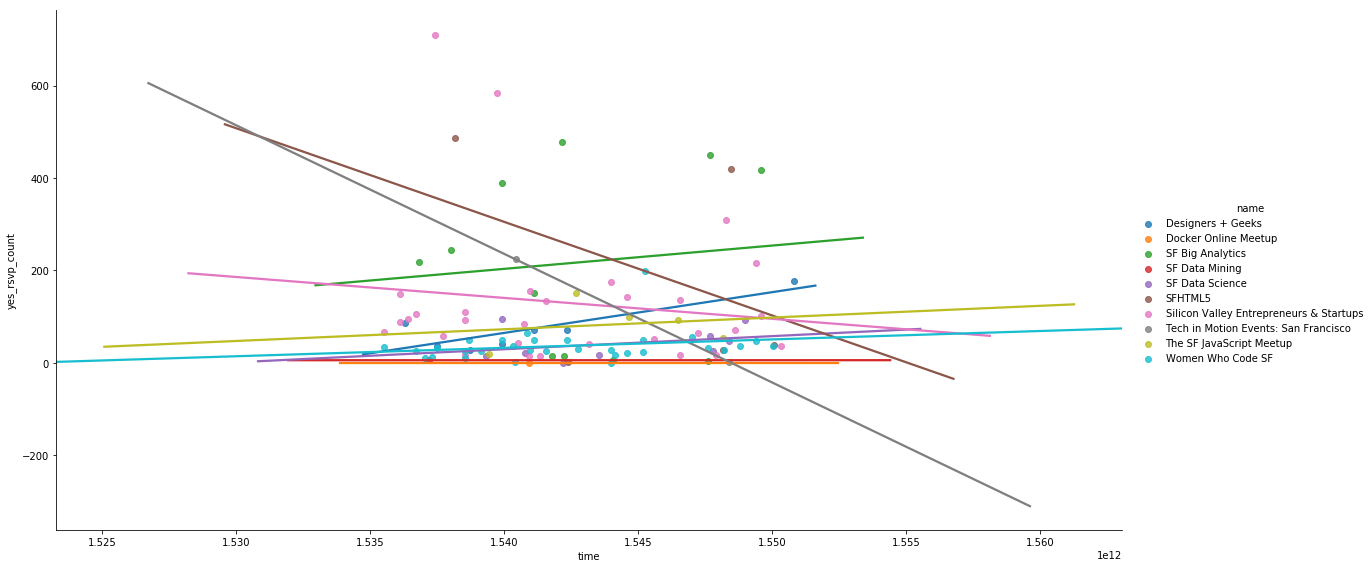

In [34]:
# import statsmodels.api as sm
sb.lmplot("time", "yes_rsvp_count", data=final_df, hue="name", height=8, aspect=2, order=1, ci=None)

### Ah, this is interesting

From the top 10 mega-groups I can see that several groups have major problems.
For instance, the **Docker Online Meetup** group has almost no yes_rsvp_counts.

Let's take a closer look.

In [35]:
interesting_group_df = final_df[final_df['name'] == "Docker Online Meetup"]
interesting_group_df

,name,time,time_dt,duration,yes_rsvp_count,id
40,Docker Online Meetup,1540915200000,10/30/18 16:00,"1 hours, 0 minutes",1,1


### Yikes, are there other mega-groups with no RSVPs?

In [36]:
rsvp_df = final_df.groupby(['id'], as_index=False).mean()

rsvp_df = rsvp_df.sort_values(by=['yes_rsvp_count', 'id'], ascending=[True, True])
rsvp_df

,id,time,yes_rsvp_count
1,1,"1,540,915,200,000.00",1.00
3,3,"1,537,200,000,000.00",6.00
9,9,"1,542,342,600,000.00",37.03
4,4,"1,544,287,200,000.00",41.89
0,0,"1,540,952,228,571.43",73.43
8,8,"1,544,289,840,000.00",83.80
7,7,"1,544,405,400,000.00",113.50
6,6,"1,542,303,840,000.00",130.30
5,5,"1,545,455,880,000.00",194.80
2,2,"1,542,816,163,636.36",217.73


### Okay, we have two mega-groups that nobody really RSVPs for....

Let's exclude those now.

In [38]:
final_df = final_df[~final_df['id'].isin([1, 3])]

### Let's also make sure that our groups meet frequently enough


In [39]:
event_count_df = final_df.groupby(['id'], as_index=False).count()
event_count_df = event_count_df.sort_values(by=['name', 'id'], ascending=[True, True])
event_count_df

,id,name,time,time_dt,duration,yes_rsvp_count
5,7,2,2,2,2,2
3,5,5,5,5,5,5
6,8,5,5,5,5,5
0,0,7,7,7,7,7
2,4,9,9,9,9,9
1,2,11,11,11,11,11
4,6,30,30,30,30,30
7,9,31,31,31,31,31


### Hmm... a few of our groups meet rather infrequently

Let's remove those as well.

In [40]:
final_df = final_df[~final_df['id'].isin([7, 5, 8, 0])]

### Let's try this again, only with the remaining 4 mega-groups

This time we're going to do two more things:
1.  Show our Confidence Interval. This adds a translucent band showing which events had a number of RSVPs within a single Standard Deviation of the mean.
2.  Estimate a [**robust regression**](https://en.wikipedia.org/wiki/Robust_regression), to de-weight outliers

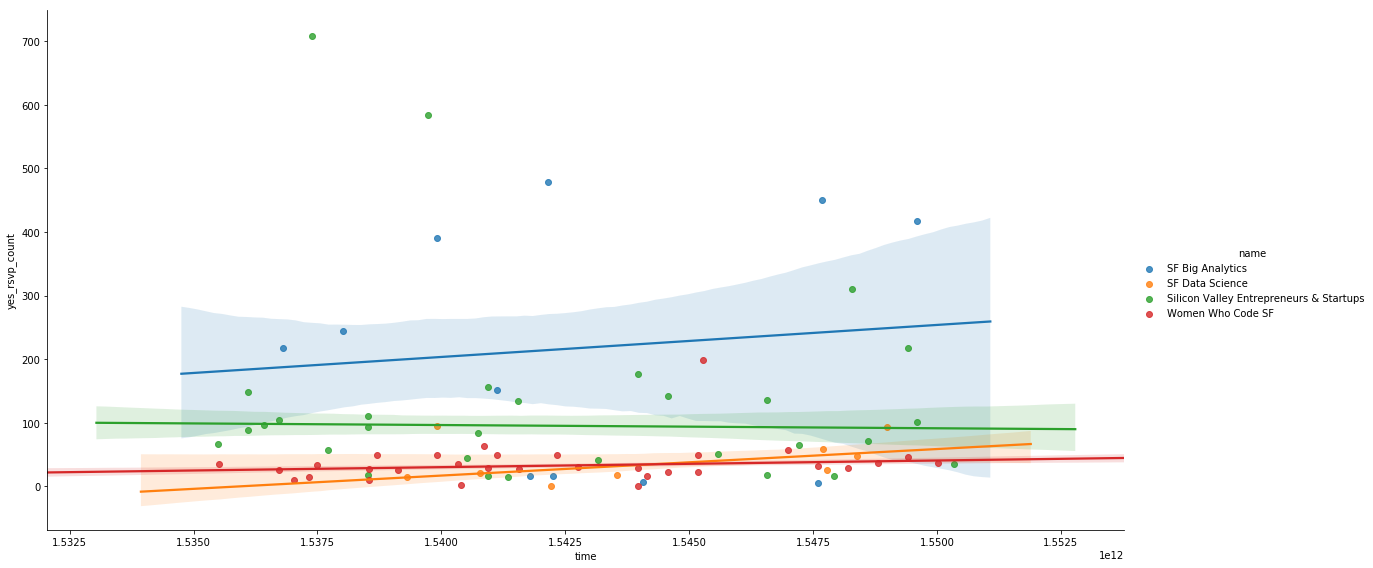

In [41]:
%%capture --no-display
sb.lmplot("time", "yes_rsvp_count", data=final_df, hue="name", 
          height=8, aspect=2, order=1,
          ci=68,       # 1. Confidence interval of 1 Standard Deviation
          robust=True) # 2. estimate a robust regression, to de-weight outliers

## Looking at the for the four remaining lines, we can see that

### Gold Medal -- [SF Big Analytics](https://www.meetup.com/SF-Big-Analytics/)
* PROs
    * the largest mean number of RSVPs
    * a slope for the trendline that indicates that it's getting even more popular
* CONs
    * the confidence interval shows a pretty thick blue bar, which means that the yes RSVPs are pretty hit-and-miss.  Check each event in advance, so that you're not surprised
            
### Silver Medal -- [Silicon Valley Entrepreneurs & Startups](https://www.meetup.com/sventrepreneurs/)
* PROs
    * holding onto a flat trend of about 100 yes-RSVPs per meeting
    * Met 31 times in the past 3 months
* CONs
    * The trend is flat, so it's not really showing signs of getting more popular
    
### Bronze Medal # 1 -- [SF Data Science](https://www.meetup.com/SF-Data-Science/)
* PROs
    * Show a pretty aggresive slope for the trend line, it's definitely rising in popularity.
* CONs 
    * Meets up the least frequently of the four top mega-groups, just about monthly
    
### Bronze Medal # 2 -- [Women Who Code SF](https://www.meetup.com/Women-Who-Code-SF/)
* PROs
    * Met up 31 times in the past 9 months (that's almost weekly)
    * Smallest variance in  RSVPs, perhaps indicating a loyal following
* CONs
    * Smallest average number of RSVPs
    

## Goal Achieved!

At last!  We found the four best Tech groups in San Francisco, CA that:
1.  are among the 10 biggest in the city
2.  that are popular and are staying popular
3.  holds events at least monthly

## Conclusion

We achieved our objectives and demonstrated several useful techniques along the way we :
1.  worked with the [Python Meetup API client]
2.  built a helper function to parse response objects into **meta** and **results** dataframes
3.  built a helper function to loop through multiple API calls and [concat]-enate a list of pages into a single useful dataframe
4.  Used pandas.DataFrame.[query] to sort and filter data of interest
5.  Used pandas.DataFrame.[apply] to clean columns of data using custom helper functions
6.  Used pandas.DataFrame.[describe] to get descriptive statistics that summarize
    * the central tendency
    * dispersion
    * shape of our dataset's distribution
7.  Used pandas.DataFrame.[merge] to join the **events** and **groups** dataframes to create a report of the events for our 10 biggest mega-groups in technology
8.  Used visualizations and statistics to filter those 10 mega-groups into the 4 very best tech groups in San Francisco


[//]: # (References)

[Python Meetup API client]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#api-client-details
[concat]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
[query]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html
[apply]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
[describe]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html
[merge]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html